# TensorFlow Inference: Small vs Large Batch Sizes (Fixed Sync)

This notebook measures how **batch size** affects **inference latency and throughput** on CPU and (if available) GPU.

It builds a simple MLP (fully connected network) and runs forward passes for multiple batch sizes. For each
configuration it reports per-call latency (seconds/iter) and throughput (samples/second), summarizing results in a table and plots.

This version **does not use** `tf.experimental.async_wait()` (which is missing on some TF builds). Instead it forces synchronization by materializing a scalar to host.


In [1]:
import time, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow:", tf.__version__)
print("Python:", platform.python_version())
print("NumPy:", np.__version__)

cpus = tf.config.list_physical_devices('CPU')
gpus = tf.config.list_physical_devices('GPU')
print("CPUs:", cpus)
print("GPUs:", gpus)

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except Exception as e:
        print("Could not set memory growth:", e)


TensorFlow: 2.16.2
Python: 3.10.18
NumPy: 1.26.4
CPUs: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPUs: []


## Configuration
Adjust model size, batch sizes, and timing parameters below.

In [2]:
# Model config
INPUT_DIM = 4096
HIDDEN_UNITS = 512
NUM_HIDDEN = 4
OUTPUT_DIM = 1024
DTYPE = tf.float32  # change to tf.float64 if desired

# Benchmark config
BATCH_SIZES = [1, 8, 32, 128, 512, 2048]
WARMUP = 5
ITERS = 20

# Devices to test
DEVICES = ['/CPU:0'] + (['/GPU:0'] if tf.config.list_physical_devices('GPU') else [])
DEVICES

['/CPU:0']

## Build model
We build a simple dense network with ReLU activations. Only inference (no training) is measured.

In [3]:
def build_mlp(input_dim=INPUT_DIM, hidden_units=HIDDEN_UNITS, num_hidden=NUM_HIDDEN, output_dim=OUTPUT_DIM, dtype=DTYPE):
    inp = keras.Input(shape=(input_dim,), dtype=dtype)
    x = inp
    for _ in range(num_hidden):
        x = layers.Dense(hidden_units, activation='relu', dtype=dtype)(x)
    out = layers.Dense(output_dim, dtype=dtype)(x)
    return keras.Model(inp, out)

model = build_mlp()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,410,944 (13.01 MB)

 Trainable params: 3,410,944 (13.01 MB)

 Non-trainable params: 0 (0.00 B)

## Benchmark helpers
We time only the forward pass and force synchronization to obtain accurate latency per iteration.

We use a portable `_sync()` function that either calls `tf.experimental.sync_devices()` if available or materializes a scalar to host via `.numpy()`.

In [4]:
_HAS_SYNC = hasattr(tf.experimental, 'sync_devices')

def _sync(tensor_like=None):
    """Force device synchronization across TF versions.
    If tf.experimental.sync_devices exists, use it; otherwise fetch a tiny scalar.
    """
    if _HAS_SYNC:
        # Newer TFs: explicit sync primitive
        tf.experimental.sync_devices()
        return
    # Fallback: materialize a scalar on host to block until ops finish
    if tensor_like is None:
        _ = tf.constant(0).numpy()
        return
    try:
        if isinstance(tensor_like, (list, tuple)) and tensor_like:
            _ = tf.reduce_sum(tensor_like[0]).numpy()
        else:
            _ = tf.reduce_sum(tensor_like).numpy()
    except Exception:
        _ = tf.constant(0).numpy()

def median(x):
    x = sorted(x)
    n = len(x)
    return x[n//2] if n % 2 else 0.5*(x[n//2-1] + x[n//2])

def bench_infer(model, batch_size, device, warmup=WARMUP, iters=ITERS, dtype=DTYPE):
    # Prepare a fixed random batch
    batch = tf.random.normal((batch_size, INPUT_DIM), dtype=dtype)
    @tf.function(jit_compile=False)
    def run(x):
        return model(x, training=False)

    # Warm-up
    with tf.device(device):
        for _ in range(warmup):
            y = run(batch)
            _sync(y)

        # Timed runs
        times = []
        for _ in range(iters):
            t0 = time.perf_counter()
            y = run(batch)
            _sync(y)
            t1 = time.perf_counter()
            times.append(t1 - t0)

    # Metrics
    lat_med = median(times)
    lat_mean = float(np.mean(times))
    thr_med = batch_size / lat_med
    thr_mean = batch_size / lat_mean
    return lat_med, lat_mean, float(np.std(times)), thr_med, thr_mean


## Run benchmark
For each device and batch size we compute latency (seconds per forward call) and throughput (samples/second).

In [5]:
results = []
for dev in DEVICES:
    with tf.device(dev):
        mdl = build_mlp()
        # Dry call to create variables on the specific device
        y0 = mdl(tf.random.normal((1, INPUT_DIM), dtype=DTYPE))
        _sync(y0)
    for bs in BATCH_SIZES:
        try:
            lat_med, lat_mean, lat_std, thr_med, thr_mean = bench_infer(mdl, bs, dev)
            res = {
                'device': dev,
                'batch_size': bs,
                'latency_median_s': lat_med,
                'latency_mean_s': lat_mean,
                'latency_std_s': lat_std,
                'throughput_median_sps': thr_med,
                'throughput_mean_sps': thr_mean,
            }
            results.append(res)
            print(res)
        except Exception as e:
            print(f"[SKIP] {dev} bs={bs}: {e}")

df = pd.DataFrame(results)
df_sorted = df.sort_values(['device','batch_size'])
df_sorted

{'device': '/CPU:0', 'batch_size': 1, 'latency_median_s': 0.0008740000193938613, 'latency_mean_s': 0.0008653400000184774, 'latency_std_s': 0.00010444411313388509, 'throughput_median_sps': 1144.164734336645, 'throughput_mean_sps': 1155.6151339111184}
{'device': '/CPU:0', 'batch_size': 8, 'latency_median_s': 0.001246550033101812, 'latency_mean_s': 0.0012928100069984794, 'latency_std_s': 0.0003554539524948478, 'throughput_median_sps': 6417.712717148996, 'throughput_mean_sps': 6188.070912734983}
{'device': '/CPU:0', 'batch_size': 32, 'latency_median_s': 0.0016780999721959233, 'latency_mean_s': 0.0018754250020720064, 'latency_std_s': 0.00039434991409102146, 'throughput_median_sps': 19069.185704189917, 'throughput_mean_sps': 17062.799080019606}
{'device': '/CPU:0', 'batch_size': 128, 'latency_median_s': 0.003924499993445352, 'latency_mean_s': 0.004146615002537146, 'latency_std_s': 0.0005219895608335526, 'throughput_median_sps': 32615.619878655605, 'throughput_mean_sps': 30868.551799885445}
{

,device,batch_size,latency_median_s,latency_mean_s,latency_std_s,throughput_median_sps,throughput_mean_sps
0,/CPU:0,1,0.000874,0.000865,0.000104,1144.164734,1155.615134
1,/CPU:0,8,0.001247,0.001293,0.000355,6417.712717,6188.070913
2,/CPU:0,32,0.001678,0.001875,0.000394,19069.185704,17062.799080
3,/CPU:0,128,0.003924,0.004147,0.000522,32615.619879,30868.551800
4,/CPU:0,512,0.006264,0.006291,0.000324,81734.951726,81391.864391
5,/CPU:0,2048,0.017340,0.017465,0.000325,118105.695409,117260.076357


## Save results

In [ ]:
"""
out_csv = 'tf_infer_batchsize_results.csv'
df_sorted.to_csv(out_csv, index=False)
print('Saved:', out_csv)
"""


## Plot: Latency vs Batch Size (per call)

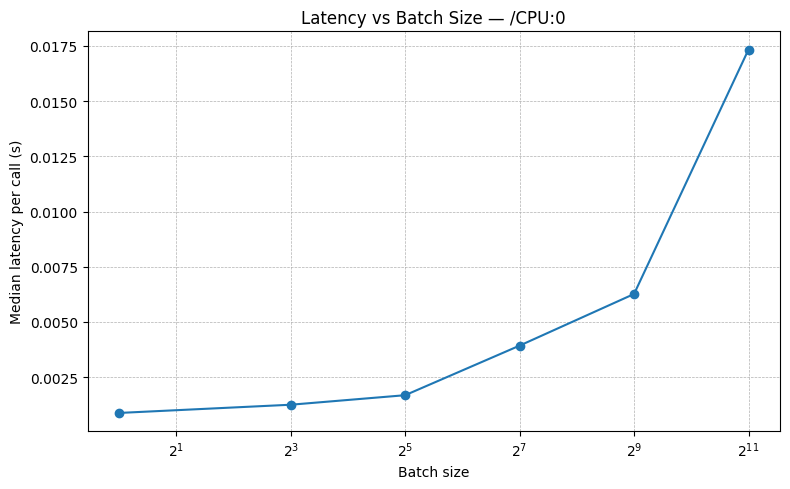

In [6]:
for dev in df_sorted['device'].unique():
    sub = df_sorted[df_sorted['device'] == dev]
    plt.figure(figsize=(8,5))
    plt.plot(sub['batch_size'], sub['latency_median_s'], marker='o')
    plt.xlabel('Batch size')
    plt.ylabel('Median latency per call (s)')
    plt.title(f'Latency vs Batch Size — {dev}')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xscale('log', base=2)
    plt.tight_layout()
    plt.show()


## Plot: Throughput vs Batch Size (samples/sec)

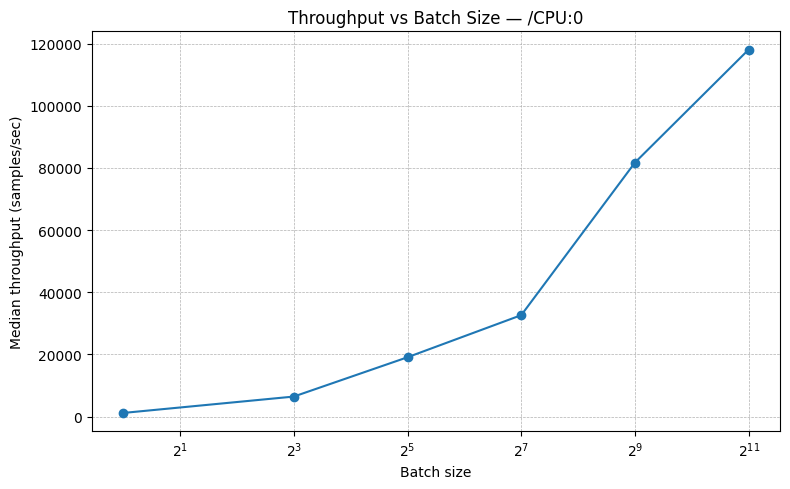

In [7]:
for dev in df_sorted['device'].unique():
    sub = df_sorted[df_sorted['device'] == dev]
    plt.figure(figsize=(8,5))
    plt.plot(sub['batch_size'], sub['throughput_median_sps'], marker='o')
    plt.xlabel('Batch size')
    plt.ylabel('Median throughput (samples/sec)')
    plt.title(f'Throughput vs Batch Size — {dev}')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xscale('log', base=2)
    plt.tight_layout()
    plt.show()


## Interpreting results
- **Latency** often increases with batch size (more work per call), especially on CPU.
- **Throughput** often increases with batch size (better parallel utilization), especially on GPU.
- Find the **knee** where latency is acceptable and throughput is high for your use case.
- For real workloads, ensure tensors and models use the same `dtype` and consider enabling XLA or mixed precision when appropriate.